In [3]:
import torch
from transformers import BertTokenizer
from datasets import load_dataset
import numpy as np
# Print the length of dataset train dialogue and summary in histogram
import matplotlib.pyplot as plt

from datasets import load_dataset


c:\Users\anime\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def reduce_dataset_sizes(dataset, train_split=100, val_split=20, test_split=30):
    for (
        split_name
    ) in dataset.keys():  # Iterate through all splits ('train', 'validation', 'test')

        if split_name == "train":
            reduced_split = dataset[split_name].shuffle(seed=42).select(range(train_split))

        if split_name == "validation":
            reduced_split = dataset[split_name].shuffle(seed=42).select(range(val_split))

        if split_name == "test":
            reduced_split = dataset[split_name].shuffle(seed=42).select(range(test_split))

        dataset[split_name] = reduced_split
    return dataset

In [5]:
emotions = [
    "admiration", "amusement", "anger", "annoyance", "approval", 
    "caring", "confusion", "curiosity", "desire", "disappointment", 
    "disapproval", "disgust", "embarrassment", "excitement", "fear", 
    "gratitude", "grief", "joy", "love", "nervousness", 
    "optimism", "pride", "realization", "relief", "remorse", 
    "sadness", "surprise", "neutral"
]


In [6]:
dataset_name = "google-research-datasets/go_emotions"
dataset = load_dataset(dataset_name, "simplified")
print('Train size:', len(dataset["train"]))
print('Validation size:', len(dataset["validation"]))
print('Test size:', len(dataset["test"]))

Train size: 43410
Validation size: 5426
Test size: 5427


In [7]:
reduced_ds = reduce_dataset_sizes(dataset)
print('Train size:', len(reduced_ds["train"]))
print('Validation size:', len(reduced_ds["validation"]))
print('Test size:', len(reduced_ds["test"]))

Train size: 100
Validation size: 20
Test size: 30


In [8]:
print(reduced_ds["train"]["labels"][:10])

[[9, 25], [5], [27], [5], [3], [17], [27], [0], [4], [27]]


In [9]:
def print_histogram(texts, labels, dataset_type):
  input_lengths = [len(text) for text in texts]
  # Have more label in x axis
  plt.hist(input_lengths, bins=20)
  plt.xlabel("Text Length")
  plt.ylabel("Frequency")
  plt.title(f"Distribution of Text Lengths ({dataset_type})")
  plt.show()

  labels = [item for sublist in labels for item in sublist]
  
  plt.hist([emotions[label] for label in labels], bins=20)
  plt.xlabel("Labels")  
  plt.xticks(rotation=90)
  plt.ylabel("Frequency")
  plt.title(f"Distribution of Labels ({dataset_type})")
  plt.show()

0


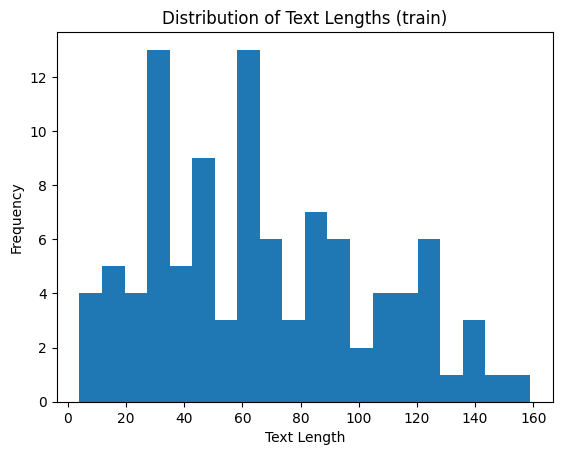

[9, 25, 5, 27, 5, 3, 17, 27, 0, 4, 27, 0, 6, 10, 5, 0, 26, 3, 9, 6, 27, 15, 20, 9, 7, 8, 1, 10, 4, 10, 4, 7, 27, 26, 27, 18, 3, 1, 26, 27, 27, 27, 0, 18, 25, 4, 8, 17, 15, 9, 27, 20, 11, 15, 2, 3, 27, 15, 27, 20, 7, 27, 27, 15, 6, 27, 27, 4, 27, 3, 3, 15, 27, 27, 27, 15, 22, 13, 27, 7, 27, 27, 15, 27, 27, 27, 27, 0, 7, 9, 0, 27, 18, 18, 5, 25, 5, 17, 10, 11, 1, 0, 27, 1, 4, 27, 27, 8, 18, 20, 17, 0, 8]


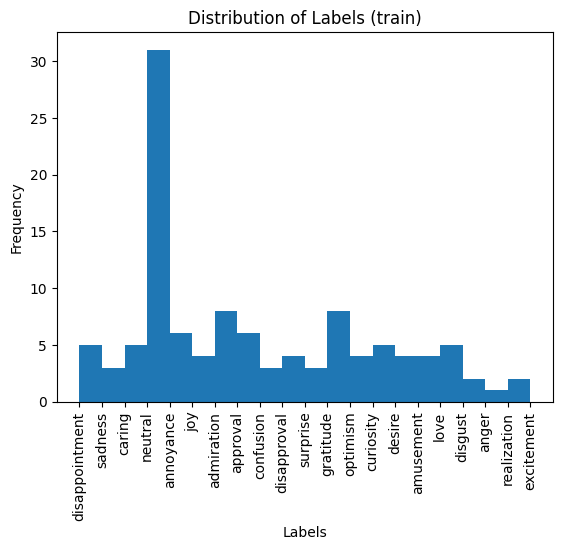

0


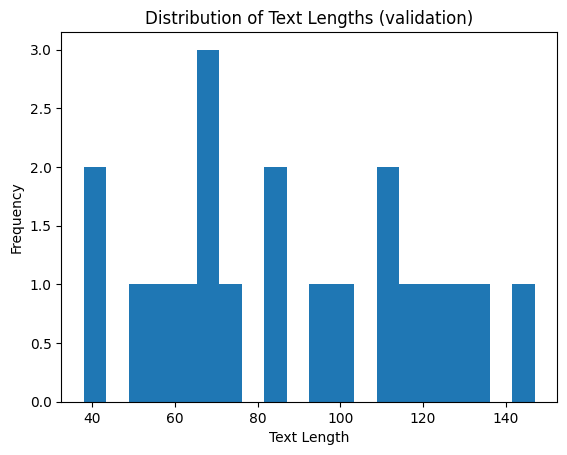

[6, 27, 4, 25, 6, 3, 7, 2, 10, 5, 12, 22, 10, 1, 27, 11, 27, 27, 5, 0, 27]


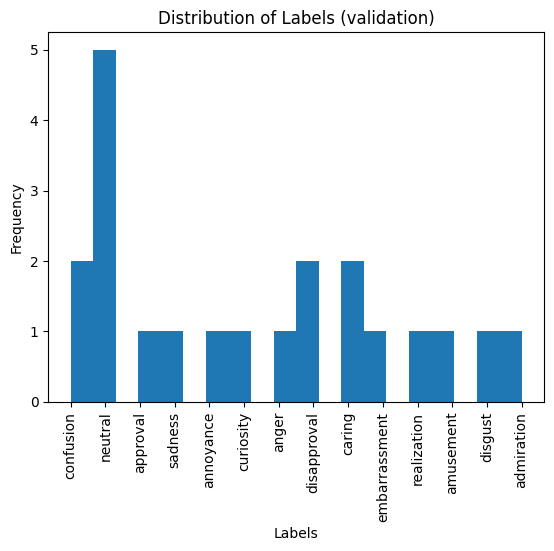

In [26]:
print_histogram(dataset["train"]["text"], dataset["train"]["labels"], 'train')

print_histogram(dataset["validation"]["text"], dataset["validation"]["labels"], "validation")


In [ ]:

def tokenize_dataset(dataset, tokenizer, params):
    max_source_length = params["max_source_length"]
    prefix = params["prefix"]

    def tokenize_function(examples):
        inputs = [prefix + doc for doc in examples["text"]]
        model_inputs = tokenizer(
            inputs,
            padding="max_length",
            truncation=True,
            max_length=max_source_length,
        )

        num_labels = params["num_labels"]
        label_vectors = [
            [1.0 if i in labels else 0.0 for i in range(num_labels)]
            for labels in examples["labels"]
        ]

        model_inputs["labels"] = torch.tensor(label_vectors, dtype=torch.float32)
        return model_inputs

    return dataset.map(tokenize_function, batched=True, remove_columns=["text", "id"])

